In [28]:
import torch
import sys
import re
import os
import pickle
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == 'cpu':
    file_path = './kaggleData/data/eng-cmn.txt'
else:
    file_path = '/kaggle/input/eng-cmn/eng-cmn.txt'
    sys.path.append('/kaggle/input/eng-cmn')

# create a folder to store ouputs
folder_path = './misc'
try:
    os.mkdir(folder_path)
except Exception as e:
    print(f'{e}')

[WinError 183] 当文件已存在时，无法创建该文件。: './misc'


In [29]:
# load datasets
text_pairs = []
with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:

        parts = line.strip().split('\t')
        

        if len(parts) < 3:
            continue
            
        en_text = parts[0].strip()
        zh_text = parts[1].strip()
        

        if en_text and zh_text:

            text_pairs.append((zh_text, en_text))

def split_chinese_english(s):

    pattern = re.compile(r'([\u4e00-\u9fff]+)|([^\u4e00-\u9fff]+)')
    result = []
    for block in pattern.findall(s):
        chinese_part, non_chinese_part = block
        if chinese_part:
            
            result.extend(list(chinese_part))
        elif non_chinese_part:

            subparts = non_chinese_part.lower().split()
            for sub in subparts:

                processed = re.sub(r'[^a-zA-Z]', '', sub)
                if processed:
                    result.append(processed)
    return result
    


In [30]:
from collections import defaultdict

def build_vocab(text_pairs, unknown = True):
    '''
    text_pairs: raw cn-eng text pair
    unknown: whether to deal with unkonwn words
    '''
    vocab = defaultdict(lambda: len(vocab))
    special_tokens = ["<pad>", "<sos>", "<eos>", "<sep>"]
    for token in special_tokens:
        vocab[token]

    for ch, en in text_pairs:
        ch = split_chinese_english(ch)
        for char in ch:
            vocab[char]
        en = split_chinese_english(en)
        for char in en:
            vocab[char]
    # add <unk> to the las of the vocab to deal with unknown words
    if unknown:    
        vocab['<unk>']
    
    # freeze vocab (check usage of 'defaultdict')
    vocab.default_factory = None
    
    return vocab

def text_to_ids(text, vocab):
    unk_id = vocab['<unk>']
    split = split_chinese_english(text)
    # print(split)
    ids = [vocab.get(id, unk_id) for id in split]
    return ids

In [31]:
# build vocab
vocab = build_vocab(text_pairs)

In [38]:
# build dataset

from torch.utils.data import Dataset, DataLoader

class TranslationDataset(Dataset):
    def __init__(self, pairs, vocab, max_len=50, pad = True):
        self.pairs = pairs
        self.vocab = vocab
        self.max_len = max_len
        self.pad = pad

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        ch, en = self.pairs[idx]

        input_ids_cn_eng = (
            [self.vocab["<sos>"]] +
            text_to_ids(ch, self.vocab) +
            [self.vocab["<sep>"]] +
            text_to_ids(en, self.vocab) +
            [self.vocab["<eos>"]]
        )

        input_ids_cn_eng = input_ids_cn_eng[:self.max_len]
        src = input_ids_cn_eng[:-1]
        tgt = input_ids_cn_eng[1:]

        if self.pad:
            # pad to max_len
            # ================================================================
            src += [self.vocab["<pad>"]]* (self.max_len - len(src))
            tgt += [self.vocab["<pad>"]]* (self.max_len - len(tgt))
            # ================================================================

        return torch.tensor(src), torch.tensor(tgt)

In [39]:
# hyper params
# gpt config:
GPT_CONFIG_124M = {
"vocab_size": len(vocab), # vocabulary size
"context_length": 128, # context length: max sequence length the model can handle 
"emb_dim": 64, # embedding dimension
"n_heads": 4, # number of attention heads
"n_layers": 4, # number of layers
"drop_rate": 0.0, # dropout rate
"qkv_bias": False # query-key-value bias
}

batch_size = 32
max_epoch = 80
eval_num = 100 # number of examples to eval after finish training
plot_loss_name = 'gpt_loss.png'
weights_name = "gpt_weights.pth"



dataset = TranslationDataset(text_pairs, vocab, GPT_CONFIG_124M['context_length'])
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [7]:
# define a simple gpt:
# from BuildingBlocks import MultiHeadAttention

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias = False):
        super().__init__()
        assert (d_out % num_heads == 0), 'd_out must be divisible by num_heads'

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.W_query = nn.Linear(d_in, d_out, bias = qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias = qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias = qkv_bias)

        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal = 1))
        # extract attention weights
        self.attentions = 0

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        # split the matrix by adding a num_heads dimension. Then we unroll the last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim).

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transposes from shape (b, num_tokens, num_heads, head_dim) to (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        attn_scores = queries @ keys.transpose(2, 3)
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores/keys.shape[-1]**0.5, dim = -1)

        # extract attentions weights for later visualization
        self.attentions = attn_weights

        # dropout
        attn_weights = self.dropout(attn_weights)
        
        context_vec = (attn_weights @ values).transpose(1, 2)
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)

        # to adjust output_dim, so that output_dim = input_dim, this is required for residual connection
        context_vec = self.out_proj(context_vec)
        return context_vec
    
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim = -1, keepdim = True)
        # unbiased=False: divided by n instead of n-1
        var = x.var(dim = -1, keepdim = True, unbiased = False)
        norm_x = (x-mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift
    
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5*x*(1+torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 *torch.pow(x, 3))
        ))
    
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            # (2, 3, 768)->(2, 3, 3072)
            nn.Linear(cfg["emb_dim"], 4*cfg["emb_dim"]),
            # (2,3,3072) -> (2,3,3072)
            GELU(),
            # (2,3,3072)->(2,3,768)
            nn.Linear(4*cfg["emb_dim"], cfg["emb_dim"]),
        )
    def forward(self, x):
        return self.layers(x)
    
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in = cfg["emb_dim"],
            d_out = cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads = cfg["n_heads"],
            dropout = cfg["drop_rate"],
            qkv_bias = cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])
    def forward(self, x):

        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        return x
    
# GPT def
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        # transformer block
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias = False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device = in_idx.device)
        )

        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [8]:
import matplotlib.pyplot as plt
# plt.switch_backend('agg')
import numpy as np

def plotLoss(training_loss, max_epochs, out_name):
    epochs = list(range(5, max_epochs+1, 5))  # [5,10,...,80]

    plt.figure(figsize=(8, 6))

    line = plt.plot(epochs, training_loss, 
                    marker='o',          
                    markersize=8,        
                    markerfacecolor='red', 
                    markeredgecolor='black', 
                    linewidth=2, 
                    linestyle='--', 
                    color='steelblue')
    plt.xticks(epochs, fontsize=10, rotation=45) 
    plt.yticks(np.arange(0, 6.5, 0.25), fontsize=10) 
    plt.xlabel('Training Epochs (5-80, step=5)', 
            fontsize=12, labelpad=10, weight='bold')
    plt.ylabel('Loss Value', 
            fontsize=12, labelpad=10, weight='bold')
    plt.title('Training Loss (5-epoch Intervals)', 
            fontsize=14, pad=20, weight='bold')

    plt.grid(True, linestyle='--', alpha=0.7, which='both')


    last_point = (epochs[-1], training_loss[-1])
    plt.annotate(f'Final Loss: {training_loss[-1]:.2f}',
                xy=last_point,
                xytext=(last_point[0]-10, last_point[1]+0.2),
                arrowprops=dict(arrowstyle='->', color='gray'),
                fontsize=10)


    plt.xlim(0, 85)
    plt.ylim(min(training_loss)-0.5, max(training_loss)+0.5)
    plt.tight_layout()
    plt.savefig(os.path.join(folder_path, out_name))
    plt.show()

In [9]:
# initialize model and start training

model = GPTModel(GPT_CONFIG_124M).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

criterion = nn.CrossEntropyLoss(ignore_index = -100)
ignore_index = [0] # ignore <pad>

plot_losses = []
plot_every = 5

In [ ]:

# training loop cn-eng:
for epoch in range(max_epoch):
    total_loss = 0
    for src, tgt in dataloader:
        src = src.to(device)
        tgt = tgt.to(device)
        # print(tgt)
        msk = torch.isin(tgt, torch.tensor(ignore_index).to(device))
        tgt[msk] = -100

        optimizer.zero_grad()
        output = model(src)
        
        loss = criterion(output.view(-1, GPT_CONFIG_124M['vocab_size']), tgt.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if (epoch+1) % plot_every == 0:
        avg_loss = total_loss/len(dataloader)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")
        plot_losses.append(avg_loss)

# save loss
with open(os.path.join(folder_path, 'gpt_loss.pkl'), 'wb') as file:
    pickle.dump(plot_losses, file)

# save model
weights_path = os.path.join(folder_path, weights_name)
torch.save(model.state_dict(), weights_path)


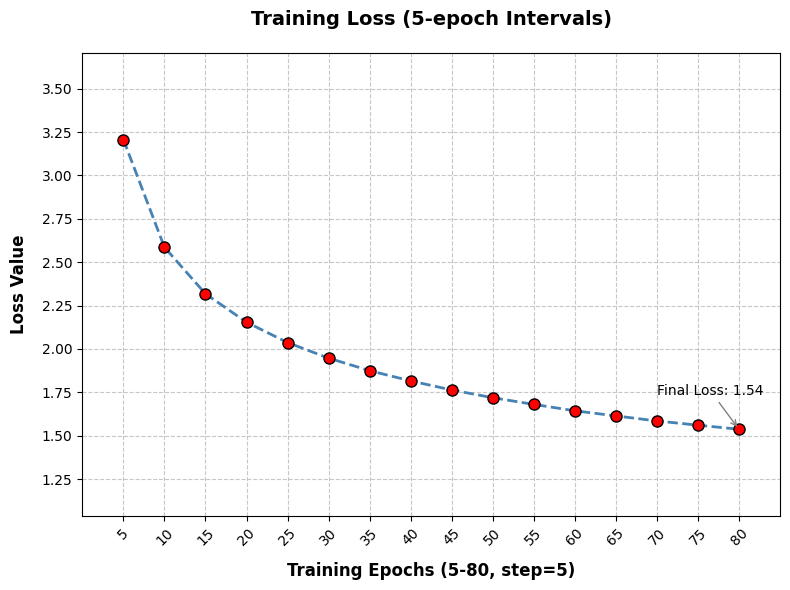

In [15]:
# reload/plot loss
with open(os.path.join(folder_path, 'gpt_loss.pkl'), 'rb') as file:
    plot_losses = pickle.load(file)

plotLoss(plot_losses, max_epoch, plot_loss_name)

In [18]:
# reload model
model = GPTModel(GPT_CONFIG_124M).to(device)
model.load_state_dict(torch.load(weights_path, map_location=device))

<All keys matched successfully>

In [19]:
# def a func to translate chinese to english
def translate_cn_eng(model, ch_text, vocab, max_len=80):
    model.to(device)
    model.eval()

    input_ids = (
        [vocab["<sos>"]] +
        text_to_ids(ch_text, vocab) +
        [vocab["<sep>"]]
    )
    input_tensor = torch.tensor([input_ids], device=device)


    for _ in range(max_len):
        if len(input_ids) >50:
            # print('max length hit')
            break
        output = model(input_tensor)

        # extract the last words of output as the predicted words
        # [0, -1]: 0 for batch, since we only have 1 data per batch
        next_token = output[0, -1].argmax().item()
        # print(next_token)
        input_ids.append(next_token)
        if next_token == vocab["<eos>"]:
            print('predict ends')
            break
        

        input_tensor = torch.tensor([input_ids], device=device)
    

    sep_pos = input_ids.index(vocab["<sep>"])
    en_ids = input_ids[sep_pos+1:-1]
    

    id_to_token = {v: k for k, v in vocab.items()}
    return " ".join([id_to_token[id] for id in en_ids])

In [20]:
# prepare cn-eng ids pairs for attn visualization
model.eval()
def decode(id_to_token, ids):
    input_tokens = [id_to_token[id] for id in ids.squeeze(0).tolist()]
    return input_tokens

id_to_token = {v: k for k, v in vocab.items()}

# prepare dedicated dataloader for attn visualization
dataset_eval = TranslationDataset(text_pairs, vocab, GPT_CONFIG_124M['context_length'], pad = False)
dataloader_eval = DataLoader(dataset_eval, batch_size=1, shuffle=True)

In [26]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.sans-serif'] = ['KaiTi']#['FangSong']#['Microsoft YaHei']  # use system chinese font
plt.rcParams['axes.unicode_minus'] = False    

def visualize_attention_heatmap(attention_weights, layer_idx, head_idx, input_tokens=None):
    """
    params
        attention_weights (list): list of attentions weights maxtrix of all layers, elements shape: (b, num_heads, seq_len, seq_len): tensor
        layer_idx (int): layer index: int, GPT_CONFIG_124M['n_layers']
        head_idx (int): head index: int, GPT_CONFIG_124M['n_heads']
        input_tokens (list): optional, list of words
    """

    attn_matrix = attention_weights[layer_idx][0, head_idx].detach().cpu().numpy()
    seq_len = attn_matrix.shape[0]

    # create heat map
    plt.figure(figsize=(6, 5))
    plt.imshow(attn_matrix, cmap='plasma', interpolation='nearest')
    plt.colorbar(label='Attention Weight')
    plt.title(f'Layer {layer_idx} Head {head_idx} Attention Heatmap')
    plt.xlabel('Source Positions (j)')
    plt.ylabel('Target Positions (i)')

    if input_tokens is not None:
        plt.xticks(range(seq_len), input_tokens, rotation=45)
        plt.yticks(range(seq_len), input_tokens)
    else:
        plt.xticks(range(seq_len))
        plt.yticks(range(seq_len))

    plt.tight_layout()
    plt.savefig(os.path.join(folder_path,f'attn-layer{layer_idx}-head{head_idx}.png'))
    plt.show()

In [22]:
# input a sequence to model to get attention weights for the input
src, tgt = next(iter(dataloader_eval))
src = src.to(device)
input_tokens = decode(id_to_token, src)
_ = model(src)
attention_weights = [model.trf_blocks[layer].att.attentions for layer in range(GPT_CONFIG_124M['n_layers'])]

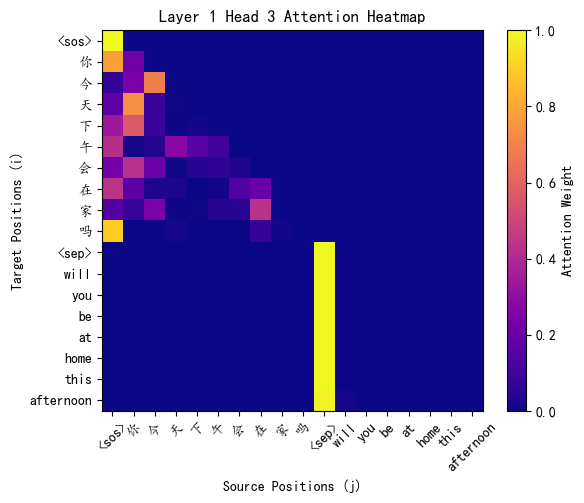

In [51]:
# visualize attention weights, 1 picture for 1 attn weights
visualize_attention_heatmap(attention_weights, layer_idx=1, head_idx=3, input_tokens=input_tokens)

In [44]:
# eval: check how model perform in translation
# chinese to english
import numpy as np
for i in np.random.randint(0, len(text_pairs), 10):
    cn = text_pairs[i][0]
    en = text_pairs[i][1]
    print(f'> {cn}')
    print(f'= {en}')
    print(f'< {translate_cn_eng(model, cn, vocab)}')
    print('='*20)


> 电视遥控器在沙发下面。
= The TV remote control is under the couch.
predict ends
< tv remote control is under the couch
> 我要控告你。
= I will sue you.
predict ends
< i want to show you
> 忘了今天的事儿吧。
= Let's forget about what happened today.
predict ends
< lets forget about what happened today
> 我没有抓到他演讲的重点。
= I didn't get the point of his speech.
predict ends
< i didnt get the point of his speech
> 语言是人们与他人交流的手段。
= Language is the means by which people communicate with others.
predict ends
< language is the means by which others quality
> 汤姆是个护士。
= Tom was a nurse.
predict ends
< tom is a nurse
> 湯姆問我喜歡不喜歡巧克力。
= Tom asked me if I liked chocolate.
predict ends
< tom asked me if i liked chocolate
> 他们亲吻了。
= They kissed each other.
predict ends
< they kissed each other
> 狗在地毯上睡觉。
= The dog was sleeping on the mat.
predict ends
< the dog was sleeping on the mat
> 我感觉好像死了一样。
= I felt like I was dead.
predict ends
< i felt like im dying a grip
